In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pathlib
from CARTO.lib import eval_utils
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
from CARTO import ROOT_DIR

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


CRITICAL:root:No module named 'asdf'
Traceback (most recent call last):
  File "/home/nickheppert/projects/CARTO/CARTO/Decoder/data/asdf_dataset.py", line 19, in <module>
    from asdf.data import SDFSamples
ModuleNotFoundError: No module named 'asdf'


In [3]:
MODEL_ID = "14i8yfym"

eval_path = ROOT_DIR / ".." / "datasets" / "encoder" / "runs"/ MODEL_ID/  "eval"

eval_path_asdf_gt = eval_path / "asdf_gt"
eval_path_asdf_no_gt = eval_path / "asdf_no_gt"
eval_path_ours = eval_path / "ours"

MAX_SAMPLES = 2000

In [4]:
eval_path.resolve()

PosixPath('/home/nickheppert/projects/CARTO/datasets/encoder/runs/14i8yfym/eval')

In [5]:
def structured_to_dict(arr: np.ndarray):
    if np.ndim(arr) == 0:
        if arr.dtype.names == None:
            return arr.item()
        # accessing by int does *not* work when arr is a zero-dimensional array!
        return {k: structured_to_dict(arr[k]) for k in arr.dtype.names}
    return [structured_to_dict(v) for v in arr]

In [6]:
def get_sorted_indices(path: pathlib.Path, max_samples=MAX_SAMPLES):
    all_files = list(pathlib.Path(path / "single_results").glob("*.npz"))
    id_list = [int(file.stem) for file in all_files]
    sorted_ids = np.argsort(id_list)
    return sorted_ids[:max_samples], all_files

In [7]:
ours_indices, ours_all_files = get_sorted_indices(eval_path_ours)
asdf_no_gt_indices, ours_asdf_no_gt = get_sorted_indices(eval_path_asdf_no_gt)
asdf_gt_indices, ours_asdf_gt  = get_sorted_indices(eval_path_asdf_gt)

print(f"{len(ours_all_files) = }")
print(f"{len(ours_asdf_no_gt) = }")
print(f"{len(ours_asdf_gt) = }")

len(ours_all_files) = 64
len(ours_asdf_no_gt) = 4
len(ours_asdf_gt) = 2


In [8]:
# eval_path = eval_path_asdf_gt
# eval_path = eval_path_asdf_no_gt
eval_path = eval_path_ours
print(f"{eval_path = }")
indices, all_files = get_sorted_indices(eval_path)

eval_path = PosixPath('/home/nickheppert/projects/CARTO/CARTO/../datasets/encoder/runs/14i8yfym/eval/ours')


# Pose and IoU

In [9]:
all_results = []

# for numpy_file in pathlib.Path(eval_path / "single_results").glob("*.npz"):
for i in indices:
    numpy_file = all_files[i]
    result = np.load(numpy_file, allow_pickle=True)["arr_0"]
    result = structured_to_dict(result)
    all_results.append(result)


In [10]:
eval_utils.compute_and_plot_mAP(eval_path, all_results, nocs_results=None)

output_path /home/nickheppert/projects/CARTO/CARTO/../datasets/encoder/runs/14i8yfym/eval/ours


100%|██████████| 64/64 [00:01<00:00, 59.72it/s]
/home/nickheppert/projects/CARTO/CARTO/lib/eval_utils.py:694: RuntimeWarning: invalid value encountered in long_scalars
  acc = np.sum(pred_matches > -1) / len(pred_matches)


72 evaluated out of 64
mAP:
3D IoU at 25: 61.0
3D IoU at 50: 41.7
3D IoU at 75: 1.4
10 degree, 10cm: 25.6
10 degree, 20cm: 56.0
10 degree, 30cm: 66.8
20 degree, 10cm: 32.2
20 degree, 20cm: 64.7
20 degree, 30cm: 76.5
Dishwasher
3D IoU at 25: 58.3
3D IoU at 50: 58.3
3D IoU at 75: 3.1
10 degree, 10cm: 36.0
10 degree, 20cm: 100.0
10 degree, 30cm: 100.0
20 degree, 10cm: 36.0
20 degree, 20cm: 100.0
20 degree, 30cm: 100.0

Knife
3D IoU at 25: 0.0
3D IoU at 50: 0.0
3D IoU at 75: 0.0
10 degree, 10cm: 0.0
10 degree, 20cm: 0.0
10 degree, 30cm: 0.0
20 degree, 10cm: 0.0
20 degree, 20cm: 0.0
20 degree, 30cm: 0.0

Laptop
3D IoU at 25: 59.0
3D IoU at 50: 44.5
3D IoU at 75: 1.4
10 degree, 10cm: 5.8
10 degree, 20cm: 23.4
10 degree, 30cm: 23.4
20 degree, 10cm: 51.9
20 degree, 20cm: 84.7
20 degree, 30cm: 91.8

Microwave
3D IoU at 25: 63.3
3D IoU at 50: 43.3
3D IoU at 75: 0.0
10 degree, 10cm: 37.5
10 degree, 20cm: 68.8
10 degree, 30cm: 68.8
20 degree, 10cm: 37.5
20 degree, 20cm: 68.8
20 degree, 30cm: 68.8


# Chamfer and Joint States

In [11]:
mean_cats, all_cats = eval_utils.get_categories_for_mean(return_all=True)
mean_cats.append(-1)

In [12]:
# Should have the same length
all_chamfers = []
all_joint_states = []
all_joint_types = []
all_gt_class_ids = []
# Total GT detections
count_detections_gt = 0
count_detections_pred = 0

for result in all_results:
    all_chamfers.extend(result["chamfer_results"])
    all_joint_states.extend(result["joint_state_results"])
    all_joint_types.extend(result["joint_type_results"])
    all_gt_class_ids.extend(result["chamfer_gt_class_ids"])
    count_detections_pred +=  len(result["chamfer_gt_class_ids"])
    count_detections_gt += len(result["chamfer_gt_class_ids"]) + result["misdetections"]

In [13]:
def compute_full_ap_and_acc(vals, start, end, steps):
    all_apcs = np.zeros((len(all_cats) + 1, steps))
    all_accs = np.zeros((len(all_cats) + 1, steps))
    thresholds = np.linspace(start, end, steps)
    for i, threshold in enumerate(thresholds):
        for class_id in mean_cats:
            if class_id != -1:
                class_idx = np.array(all_gt_class_ids) == class_id # For each class
            else:
                class_idx = np.ones_like(all_gt_class_ids, dtype=bool) # For all classes

            matches = np.ones((count_detections_pred))

            if vals.ndim > 1:
                vals = vals.flatten()
            matches[vals > threshold] = -1

            # print(chamfer_matches[class_idx])
            ap, acc = eval_utils.compute_ap_and_acc(
                matches[class_idx], vals[class_idx], np.ones((count_detections_pred))[class_idx]
            )
        #   print(f"{chamfer_threshold} {ap} {acc}")

            all_apcs[class_id, i] = ap
            all_accs[class_id, i] = acc
    return all_apcs, all_accs, thresholds

In [14]:
resolution = 1001
chamfer_apcs, chamfer_accs, chamfer_thresholds = compute_full_ap_and_acc(
    np.array(all_chamfers) * 1000, 0, 10, resolution
)
(
    joint_state_apcs,
    joint_state_accs,
    joint_state_thresholds,
) = compute_full_ap_and_acc(
    np.array(all_joint_states)[:, 0], 0, 0.5, resolution
)

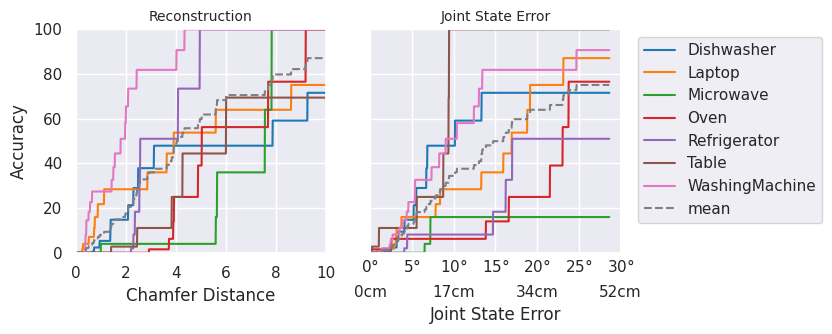

In [15]:
labels = [
    "Dishwasher", "Laptop", "Microwave", "Oven", "Refrigerator", "Table", "WashingMachine", "mean"
]

# print(f"{mean_categories = }")
#  [1, 3, 4, 5, 6, 9, 10] # 0 is background

# labels = ['bottle', 'bowl', 'camera', 'can', 'laptop', 'mug', 'mean', 'nocs']

# labels = ['bottle', 'bowl', 'camera', 'can', 'laptop', 'mug', 'mean', 'nocs']
# colors = [
#     'tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:olive', 'tab:purple', 'tab:red',
#     'tab:gray'
# ]
colors = sns.color_palette("tab10")
styles = ['-'] * (len(mean_cats) - 1) + ["--"]

fig, (ax_chamfer, ax_joint) = plt.subplots(1, 2, figsize=(8.5, 3.5))

ax_chamfer.set_title('Reconstruction', fontsize=10)
ax_chamfer.set_ylabel('Accuracy')
ax_chamfer.set_ylim(0, 100)
ax_chamfer.set_xlabel('Chamfer Distance')
ax_chamfer.set_xlim(0, 10)
ax_chamfer.xaxis.set_ticks([0, 2., 4., 6., 8., 10])
# ax_chamfer.yaxis.set_ticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
# ax_chamfer.grid()

ax_joint.set_title('Joint State Error', fontsize=10)
# ax_joint.set_ylabel('Average Precision')
ax_joint.set_ylim(0, 100)
ax_joint.yaxis.set_ticklabels([])
# ax_joint.set_xlabel('Joint State')
ax_joint.set_xlim(0, 0.5)
ticks_rad = np.array([
    0, 0.523599 / 6, 0.523599 * 2 / 6, 0.523599 * 3 / 6, 0.523599 * 4 / 6, 0.523599 * 5 / 6,
    0.523599
])
ticks_deg = (ticks_rad * 180 / np.pi).astype(int)
ax_joint.xaxis.set_ticks(ticks_rad)
ax_joint.xaxis.set_ticklabels([f"{tick}$\degree$" for tick in ticks_deg])
ax_joint.tick_params(axis=u'both', which=u'both',length=0)

# ax_joint.grid()

# secx = ax_joint.secondary_xaxis('bottom')
ax2 = ax_joint.twiny()
ax2.xaxis.set_ticks_position('bottom')  # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom')  # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 20))
# ticks_m = np.array([0., 0.15, 0.3, 0.5])
ticks_m = ticks_rad
ticks_cm = (ticks_m * 100).astype(int)[::2]
ax2.xaxis.set_ticks(ticks_m[::2])
ax2.xaxis.set_ticklabels([f"{tick}cm" for tick in ticks_cm])
ax2.set_xlabel("Joint State Error")
ax2.set_xlim(ax_joint.get_xlim())
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.grid(visible=False)

### Chamfer
for i in range(len(mean_cats)):
  class_id = mean_cats[i]

  ax_chamfer.plot(
      chamfer_thresholds,
      100 * chamfer_apcs[class_id, :],
      color=colors[i],
      linestyle=styles[i],
      label=labels[i]
  )

  ax_joint.plot(
      joint_state_thresholds,
      100 * joint_state_apcs[class_id, :],
      color=colors[i],
      linestyle=styles[i],
      label=labels[i]
  )

ax_joint.legend(bbox_to_anchor=(1.04, 1.0))
fig.tight_layout()
fig.savefig(eval_path / "mAP_chamfer_joint.png")
fig.savefig(eval_path / "mAP_chamfer_joint.pdf")
